In [4]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.8 MB/s eta 0:00:00
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.2 MB/s eta 0:00:00
  Using cached qtconsole-5.5.2-py3-none-any.whl (123 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.1 MB/s eta 0:00:00
  Using cached QtPy-2.4.1-py3-none-any.whl (93 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-inline
    Found exi

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

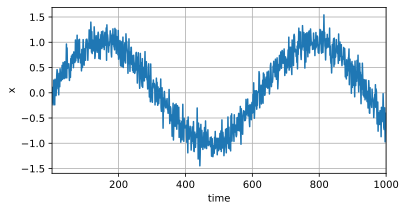

In [6]:
# Generate a sequence that are composed of sin and noise.
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))


In [11]:
# Create features of size [996, 4], and labels of size [996, 1]
tau = 4
features = torch.zeros((T-tau, tau))
print(features.shape)
for i in range(tau):
  features[:, i] = x[i : T-tau+i]
print(x.shape)
labels = x[tau:].reshape((-1,1))
print(labels.shape)
# Prepare training data with first 600 data points
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

torch.Size([996, 4])
torch.Size([1000])
torch.Size([996, 1])


In [12]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)

# Network is 2 layer, with 10 hidden nodes
def get_net():
  net = nn.Sequential(nn.Linear(4, 10),
                      nn.ReLU(),
                      nn.Linear(10, 1))
  net.apply(init_weights)
  return net

loss = nn.MSELoss(reduction='none')

In [15]:
def train(net, train_iter, loss, epochs, lr):
  trainer = torch.optim.Adam(net.parameters(), lr)
  for epoch in range(epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.sum().backward()
      trainer.step()
    print(f'epoch {epoch}, '
          f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 0, loss: 0.050745
epoch 1, loss: 0.048143
epoch 2, loss: 0.045426
epoch 3, loss: 0.044117
epoch 4, loss: 0.044514
epoch 5, loss: 0.047200
epoch 6, loss: 0.043226
epoch 7, loss: 0.045715
epoch 8, loss: 0.044116
epoch 9, loss: 0.045952


torch.Size([996, 1])


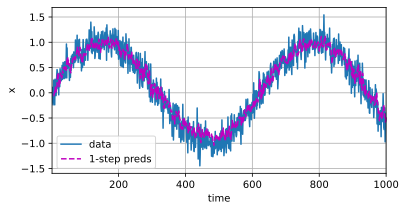

In [17]:
# Check how the model works in prediction
onestep_preds = net(features)
print(onestep_preds.shape)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1,1000],
         figsize=(6,3))

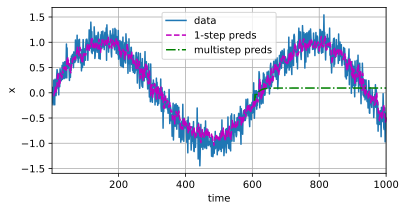

In [18]:
# use 4 actual data points, predict all remaining data points (instead of 1)
# Which doesn't work well.
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[: n_train+tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(
      multistep_preds[i-tau: i].reshape((1, -1))
  )
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))